This Notebook is for Time Series Prediction for Bitcoin Prices

Dataset is taken from https://www.coindesk.com/price/bitcoin

In [34]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
#Loading the Dataset
#Tell pandas that the first column is datetime
df = pd.read_csv('BTC_USD_2013-10-01_2021-06-02-CoinDesk.csv', parse_dates=['Date'], index_col=['Date']) 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
#Looking at more information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2801 entries, 2013-10-01 to 2021-06-02
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2801 non-null   object 
 1   Closing Price (USD)  2801 non-null   float64
 2   24h Open (USD)       2801 non-null   float64
 3   24h High (USD)       2801 non-null   float64
 4   24h Low (USD)        2801 non-null   float64
dtypes: float64(4), object(1)
memory usage: 131.3+ KB


In [7]:
#Getting only the closing prices for everyday
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


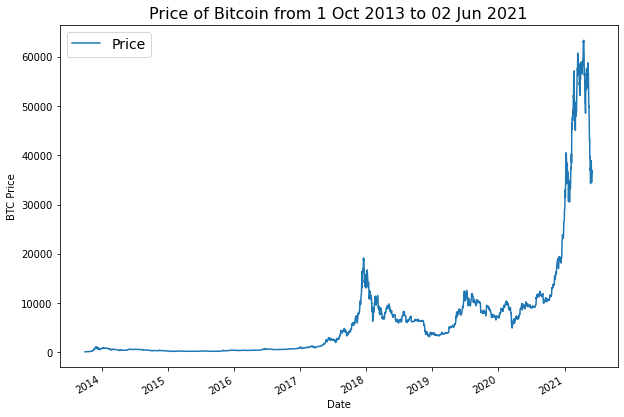

In [9]:
#Plotting all the prices to get a better look
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 02 Jun 2021", fontsize=16)
plt.legend(fontsize=14);

In [13]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [14]:
#Splitting the Dataset into Train and Test set
#In Time-seires problems splitting the dataset the normal way, which is randomly selecting 80-20 split is wrong!
#We aim to train our model on past data and hope it works on the artificial future data
#Thus splitting the dataset the orthodox way makes no sense
#Instead we create the training set as the first 80% samples and the Test set as the remaining 20% as follows


split_size = int(0.8 * len(prices)) # 80% train, 20% test

#Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

#Create Test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]


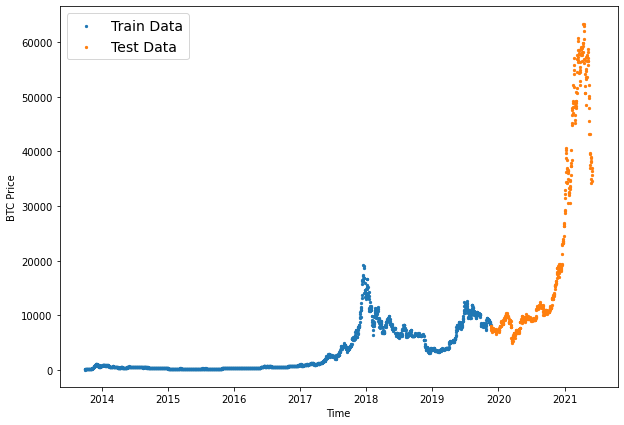

In [16]:
#Plotting the splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);
plt.show()

In [29]:
#Creating a plotting fucntion
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14);
    plt.grid(True)


Naive Model (Baseline)

In [30]:
#creating a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([8118.4885358 , 8074.84317361, 7612.7405735 , 7262.11053495,
       7303.40575852, 7041.73293642, 7211.86180875, 7141.06944869,
       7523.4806726 , 7390.20746923])

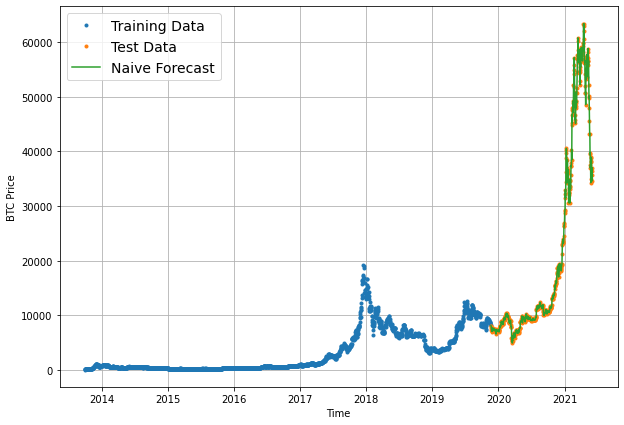

In [32]:
#Plotting the naive Forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, format=".", label='Training Data')
plot_time_series(timesteps=X_test, values=y_test, format=".",  label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", label='Naive Forecast')

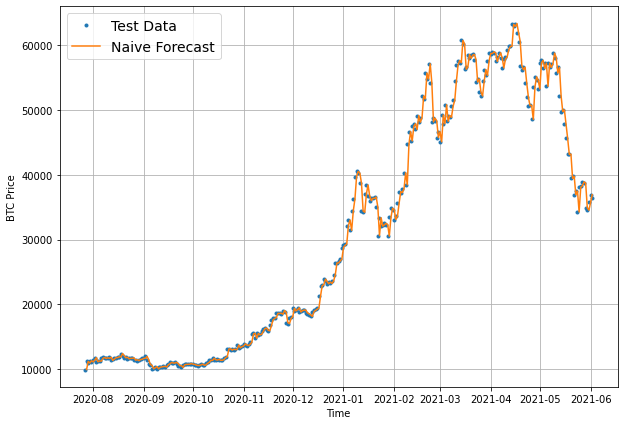

In [33]:
#zooming in on the test and naive forecast
plt.figure(figsize=(10,7))
offset=250
plot_time_series(timesteps=X_test, values=y_test, format=".", start=offset, label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", start=offset, label='Naive Forecast')

In [37]:
#Code snippet for MASE 

def mean_absolute_scaled_error(y_true, y_pred):
    #Implement MASE (assuming no seasonality of data)
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [38]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    #Calculate different evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {'mae': mae.numpy(),
           'mse': mse.numpy(),
           'rmse': rmse.numpy(),
           'mape': mape.numpy(),
            'mase': mase.numpy()}

In [40]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 602.0485,
 'mse': 1258207.5,
 'rmse': 1121.6985,
 'mape': 2.5736644,
 'mase': 0.99834347}

In [41]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [42]:
#Function to label windowed data
def get_labelled_windows(x, horizon=1):
    # example Input: [1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
    return x[:, :-horizon], x[:, -horizon:]

In [43]:
#function to view numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    #Turns a 1D array into a 2D array of sequential windows of window_size.
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes] # get the original array indexed with windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [44]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2794, 2794)

In [45]:
# Making the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [46]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2235, 559, 2235, 559)

In [47]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))